Prisha CHANDIRAMANI

This second practical work, on motion estimation, deals with parametric motion estimation. You have to reuse some of the functions you implemented during the first practical work.

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [348]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from cv2 import copyMakeBorder,BORDER_REPLICATE

# Parametric estimation
In this second practical work, we will work on parametric estimation, both using direct and indirect methods.
## I- Direct parametric estimation
## I-1 Theoretical questions

**Infinite signal**

Let $a: (n,m)\in \mathbb{Z}^2 \rightarrow \mathbb{R}$ be a bi-dimensional signal and $b(n,m)$ a signal of the same type.

**Recall the expression of the 2D discrete time Fourier transform (DTFT).**

Let us suppose that
$\exists c,d \in \mathbb{Z}^2: \forall n,m \in \mathbb{Z}^2,b(n,m) = a(n+c,m+d)$ (that is, $b$ is a translation of $a$). **Compute the DTFT** of $b$ as a function of the one of $a$ and of the displacement $(c,d)$.

**Show that the ratio between the DTFTs is:**
$$
\frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \exp(i2\pi (c\nu_x + d \nu_y))
$$

**Finite signal**

Now, $a: (n,m) \in \{0,1,...,N-1\}^2 \rightarrow \mathbb{R}$ and $b(n,m)$ are both finite signals. In that case, we use the Discrete Fourier Transform (DFT) rather than the DTFT.

**Recall the expression of the DFT.**

**Under which hypotheses is the ratio between $a$'s and $b$'s DFT a linear phase signal?**
$$
\frac{\hat{B}(k_x,k_y)}{\hat{A}(k_x,k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)
$$

**ANSWERS**

**Infinite signals**

The 2D discrete time Fourier transform (DTFT) of a signal a(n,m) is 
$$ \hat{a}(\nu_x, \nu_y) = \sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} a(n,m) \exp(-i 2\pi (n \nu_x + m \nu_y)) $$

The DTFT of b is

$$ \hat{b}(\nu_x, \nu_y) = \sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} b(n,m) \exp(-i 2\pi (n \nu_x + m \nu_y)) $$

Having b(n,m) = a(n+c,m+d), we can write :

$$ \hat{b}(\nu_x, \nu_y) = \sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} a(n+c, m+d) \exp(-i 2\pi (n \nu_x + m \nu_y)) $$

By the change of variables n' = n + c and m' = m + c, we get :

$$ \hat{b}(\nu_x, \nu_y) = \sum_{n'=-\infty}^{\infty} \sum_{m'=-\infty}^{\infty} a(n', m') \exp(-i 2\pi ((n'-c) \nu_x + (m'-d) \nu_y)) $$

We can rewrite it : 

$$ \hat{b}(\nu_x, \nu_y) = \sum_{n'=-\infty}^{\infty} \sum_{m'=-\infty}^{\infty} a(n', m') \exp(-i 2\pi (n' \nu_x + m' \nu_y)) \exp(i 2\pi (c \nu_x + d \nu_y)) $$

We can then recognize the DTFT of a and write: 

$$ \hat{b}(\nu_x, \nu_y) = \hat{a}(\nu_x, \nu_y) \exp(i 2\pi (c \nu_x + d \nu_y)) $$

Thus, the ration between the DTFTs of b and a is: 

$$ \frac{\hat{b}(\nu_x, \nu_y)}{\hat{a}(\nu_x, \nu_y)} = \exp(i 2\pi (c \nu_x + d \nu_y)) $$

**Finite Signals**

The DFT of a finite signal of size $N^2$ is : 

$$ \hat{A}(k_x, k_y) = \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} a(n,m) \exp\left(-\frac{2i\pi (n k_x + m k_y)}{N}\right) $$

Reasoning the same way as with infinite signals, we get that the ration between the DFTs of b and a is:

$$ \frac{\hat{B}(k_x, k_y)}{\hat{A}(k_x, k_y)} = \exp\left(\frac{2i\pi (c k_x + d k_y)}{N}\right) $$

The hypotheses for the ratio between a's and b's DFT to be a linear phase signal are : 

* The signals a and b must be related by a simple translation, which means b(n,m) = a(n+c, m+d) where c and d are integer offsets. 

* The translation must respect the periodic boundary conditions of the finite signal, meaning that the indices (n+c) and (m+d) are taken modulo N.

## I-2 Practical part
First, start to work on the 'ball.mat' image. We will apply a translation to this image and try to estimate the parameter of the translation.

Try by either adding or not some noise into the image.

In [349]:
im1 = loadmat('ball.mat')['im1']
im1 = im1.astype('float')

#im1 = loadmat('lena.mat')['im1']
#im1 = im1.astype('float')

N, M = np.shape(im1)

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1659a3390>)

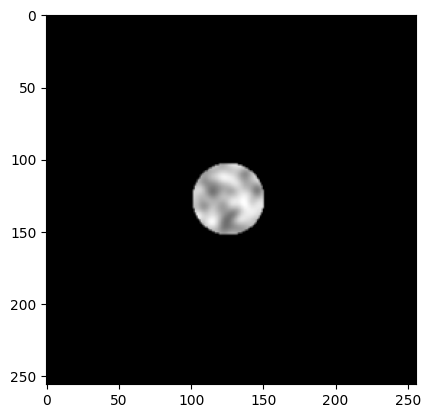

In [350]:
# Potentially add noise to the image
sigma = 0   # 0,2,5
im1_b = im1 + np.random.normal(0, sigma, (N, M))



plt.figure(),plt.imshow(im1_b,cmap='gray')

In the following, we apply a translation to the image. To do that, use the applyAffineMotion function which is already pre-implemented.

In [351]:
def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref);
    
    
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement
    
    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    
    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points
    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])    
    
    
    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp =  griddata(points, values, points_inter,'linear')
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp


def applyAffineMotion(x,b,B = np.zeros((2,2)),out = 100):
    N, M = np.shape(x)
    px, py = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1), np.arange(-(N-1)/2,(N-1)/2+1))
    
    mvfx = b[0] + B[0,0]*px + B[0,1]*py
    mvfy = b[1] + B[1,0]*px + B[1,1]*py
    
    mvf = np.zeros((np.shape(mvfx)[0],np.shape(mvfx)[1],2))
    mvf[:,:,1] = mvfx
    mvf[:,:,0] = mvfy
    
    y = fracMc(x,mvf,out)
    return y

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1655e7b10>)

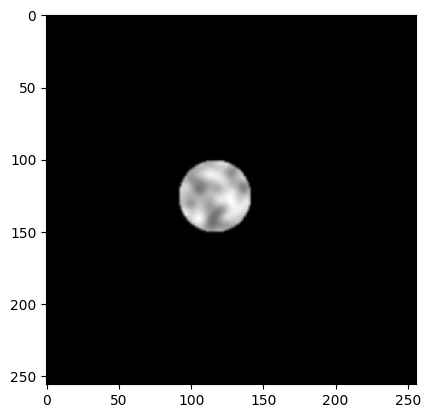

In [352]:
horiz_displacement = 9.3
vert_displacement  = 1.84
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1_b,b)
plt.figure(),plt.imshow(im2,cmap='gray')

Compute the FFT of the two images. Using the indications given in the theroretical part, describe a method with which you can find the parameters of the translation from the two FFTs.

**ANSWER:**

Once we compute the 2D FFTs of the two images, we get that the ratio between the two FFTs is a complex exponential, whose phase contains information about the translation parameters. 
$$ \frac{\hat{B}(k_x, k_y)}{\hat{A}(k_x, k_y)} = \exp\left(\frac{2i\pi (c k_x + d k_y)}{N}\right) $$

From this ratio, we can extract the phase and plot it as a function of $k_x$ and $k_y$. The phase should be a linear function of $k_x$ and $k_y$. 
$$Phase(k_x,k_y) = \frac{2\pi (c k_x + d k_y)}{N}$$
The slopes of the phase with respect to $k_x$ and $k_y$ will give the translation parameters c and d we are looking for. 

In [353]:
IM1 = np.fft.fft2(im1_b)
IM2 = np.fft.fft2(im2)

Compute the phase of the Fourier transform.

In [354]:
def angle2D(x):
    a = np.angle(x)
    
    b1 = np.unwrap(a,axis=0)
    b2 = np.unwrap(b1,axis=1)
    b3 = np.unwrap(a,axis=0)[:,::-1]
    b4 = np.unwrap(b3,axis=1)[:,::-1]
    
    y = (b2+b4)/2./(-2.*np.pi)
    return y

In [355]:
phi = angle2D(IM1/IM2)

Display phi. Is it a linear plane and why?

**Answer:**

In the case of the ball image without noise, phi is a linear plane. There is no additional noise. When plotted, we can see that the plane is linear. 
In the three other cases (ball with noise, lena without noise, lena with noise), phi is not a linear plane.

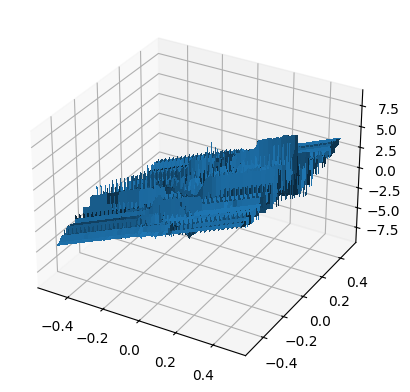

In [356]:
fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)


Translation estimation: to estimate the parameters of the translation, we are now looking for the slope of the plane.

Method 1: estimate it using the median of the gradient. To do that, complete the gradient function.

In [357]:
def gradient(M,stepX=1.,stepY=1.):
# Computes the gradient of an image, over the rows and the column directions. StepY is the assumed gap between the rows and StepX is the assumed gap between the columns

    gy = np.zeros((np.shape(M)[0],np.shape(M)[1]))
    gx = np.zeros((np.shape(M)[0],np.shape(M)[1]))
    

    gy[0:-1,:] = (M[1:,:]-M[0:-1,:])/stepY
    gx[:,0:-1] = (M[:,1:]-M[:,0:-1])/stepX

    
    return gx,gy

In [358]:
gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)

In [359]:
print(gx)
print(gy)

[[9.30283689 9.30242951 9.30125841 ... 9.30125841 9.30242951 0.        ]
 [9.30317998 9.30319657 9.30264532 ... 9.30052513 9.30209924 0.        ]
 [9.30392933 9.30463365 9.30526943 ... 9.30005732 9.30203692 0.        ]
 ...
 [9.30363081 9.30200844 9.29927549 ... 9.3104919  9.30719155 0.        ]
 [9.30312389 9.30203692 9.30005732 ... 9.30526943 9.30463365 0.        ]
 [9.30283422 9.30209924 9.30052513 ... 9.30264532 9.30319657 0.        ]]
[[1.83921253 1.83955561 1.84032267 ... 1.84027875 1.83954547 1.8392152 ]
 [1.83886359 1.83961294 1.84105003 ... 1.83910404 1.83863623 1.83857392]
 [1.83782285 1.83908418 1.84164208 ... 1.83812624 1.83734441 1.83731593]
 ...
 [1.83782285 1.83731593 1.83734441 ... 1.84686455 1.84164208 1.83908418]
 [1.83886359 1.83857392 1.83863623 ... 1.84367414 1.84105003 1.83961294]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [360]:
print(GX)
print(GY)

9.340554949721707
1.8941488530580273


Method 2: the code below computes the least Square planar approximation of phi, enabling you how to estimate the parameters of the translation. Explain how it works.

**Answer:**

First we center the value of phi to have a zero-centered mean. Then we apply the median filter to phi with a (3x3) neighborhood around each pixel. This allows us to reduce noise. 
The linear system $\phi = A[c,d]^T $ is then solved using least square by computing the pseudo-inverse of A, which contains $f_x$ and $f_y$, and multiplying it by b (filtered phi flattened). The result is stored in bEst. bEst gives the estimated displacement.

In [361]:
def medianFilter(x,N):
    z = copyMakeBorder(x, N, N, N, N, BORDER_REPLICATE)
    y = np.zeros(np.shape(x))
    
    for r in range(np.shape(x)[0]):
        for c in range(np.shape(x)[1]):
            tmp = z[r:r+2*N+1,c:c+2*N+1]
            y[r,c] = np.median(tmp)
    return y

In [362]:
phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)

In [363]:
print(bEst)

[ 9.04352802 -1.61268472]


**Relaunch the above code**:
- with and without noise
- with the lena image, instead of the ball image.

Each time, are you able to correctly estimate the translation? Why? Comment your results.

**ANSWER**

* **Ball image without noise** : We get a correct approximation. With the first method, we get [c,d] = [10,1] and with the second method, we get [c,d] = [9.99,0.99].

* **Ball image with noise (sigma = 5)** : We get an incorrect approximation. With the first method, we get [c,d] = [5.63,11.74] and with the second method, we get [c,d] = [1.39,2.39]. 

* **Lena image without noise** : We get an incorrect approximation. With the first method, we get [c,d] = [8.92,0] and with the second method, we get [c,d] = [7.90,0.01].

* **Lena image with noise (sigma = 5)** : We get an incorrect approximation. With the first method, we get [c,d] = [7.88,0.06] and with the second method, we get [c,d] = [5.19,-0.16].

Both methods work well for simple images without noise such as the ball image without noise. This is because the ball has a dominant low-frequency spectrum. Adding noise makes it difficult to extract a clear linear phase. Moreover, the lena image contains high-frenquency components which lead to phase distortions. Noise and high-frequency elements make both methods fail which explains the results observed. 

# II-Indirect parametric estimation
In this last part, we will perform indirect parametric estimation. The movement vector field will be estimated by 1) block matching; 2) optic flow. **You have to reuse here the functions that you implemented during the first practical work**. Each time, you will then estimate the translation by taking the median of the estimated vector field.

Perform the experiment without and with noise (you can then take sigma = 2).

Finally, compare all the parametric estimation methods when the translation values are not integer.

In [364]:
#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) 
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV

#%%
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV


#%%
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;

    
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    
    # Non-regularized search
    if lamb == 0.:
        print("Non-regularized search")
        for r in range(0,cur.shape[0],brow): # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0,cur.shape[1],bcol):
                # current block selection
                B = cur[r:r+brow,c:c+bcol] # Block
                #print("B shape:",B.shape)
                #print(B)

                # Initialization:
                
                costMin = np.inf
                
                Rbest = ref[r:r+brow,c:c+bcol] # Initialisation of the best block
                row_best_disp = 0
                col_best_disp = 0
                # Loop on candidate displacement vectors
                
                for dcol in range(-extension,extension): # dcol = candidate displacement vector over the columns
                    for drow in range(-extension,extension):# rcol = candidate displacement vector over the rows
                        im_test = ref_extended[r+drow+extension:r+drow+extension+brow,dcol+extension+c:c+dcol+extension+bcol] # Block in the reference image
                        #print(drow+extension,dcol+extension)
                        #print("drow,dcol:",drow,dcol)
                        #print("im shape:",im_test.shape)
                        #print(im_test)
                        SSD = np.sum((B-im_test)**2) # Sum of squared differences
                        #print("SSD:",SSD)
                        
                        if SSD<costMin: # Save the results if they are better than the previous ones
                            costMin = SSD
                            Rbest = im_test
                            row_best_disp = drow
                            col_best_disp = dcol
                            
                mvf[r:r+brow,c:c+bcol,0] = np.ones((brow,bcol))*row_best_disp # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1] = np.ones((brow,bcol))*col_best_disp # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]= Rbest
                    
    else: # Regularized search
        print("Regularized search")
        for r in range(0, cur.shape[0],brow): # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0, cur.shape[1],bcol):
                # current block selection
                B =  cur[r:r+brow, c:c+bcol]# Block

                # Initializations          
                vect = initVector(ref,cur)
                costMin = np.inf
                Rbest = ref[r:r+brow,c:c+bcol] # Initialisation of the best block
                row_best_disp = 0
                col_best_disp = 0

                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r,c,brow,bcol,mvf,ref,cur)
                
                # Loop on candidate vectors
                for dcol in range(-extension, extension): # dcol = candidate displacement vector over the columns
                    for drow in range(-extension, extension): # rcol = candidate displacement vector over the rows
                        im_test = ref_extended[r+drow+extension:r+drow+extension+brow,dcol+extension+c:c+dcol+extension+bcol]
                        vect_test = np.array([drow,dcol])
                        error = np.sum((vect_test - pV)**2)
                        SSD = np.sum((B-im_test)**2)
                        cost = SSD + lamb*error # here, encore the REGULARIZED cost function
                        if cost < costMin: # Save the results if they are better than the previous ones
                            costMin = cost
                            Rbest = im_test
                            row_best_disp = drow
                            col_best_disp = dcol
                
                
                mvf[r:r+brow,c:c+bcol,0]= np.ones((brow,bcol))*row_best_disp # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1]= np.ones((brow,bcol))*col_best_disp # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]=Rbest
                
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

In [365]:
def displayMVF(I,mvf,subsamp):
    
    row,col = np.shape(I)
    
    # Subsample dense MVF 
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]
    
    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)
    
    # Show image
    plt.figure()
    plt.imshow(I,cmap='gray')

    plt.quiver(X, Y, vectCol,-vectRow)

    
    return

Regularized search
9.0
2.0


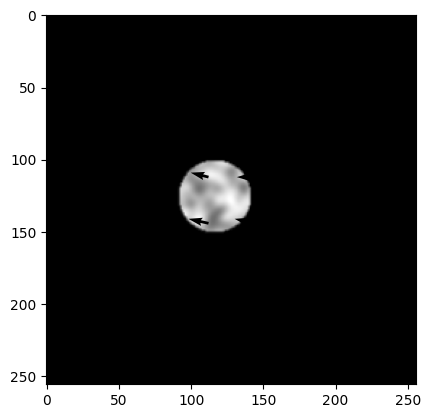

In [366]:
lamb = 5 #0,5,500
mvf,prediction = me_ssd(im2,im1_b,32,32,10,lamb)
displayMVF(im2,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)

Estimation with optic flow

In [367]:
def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx;
    fy=-fy;

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337
    
    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)
    
    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """
    
    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)
    
    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()
    
    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)
    
    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])
    
    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg= convolve2d(u,kernel_1,'same')
        vAvg= convolve2d(v,kernel_1,'same')
        
        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = uAvg - fx*(uAvg*fx + vAvg*fy + ft)/(alpha**2 + fx**2 + fy**2)
        v = vAvg - fy*(uAvg*fx + vAvg*fy + ft)/(alpha**2 + fx**2 + fy**2) 
        
        
    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

8.752503212162207
1.9540365693928734


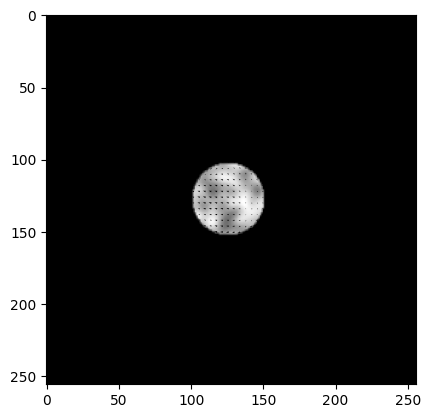

In [368]:
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1_b, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1_b,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)

**ANSWER:**

For the displacement [10,1] : 

* Ball without noise (with lamb = 5) : With the block-matching method, we get [c,d] = [10,1] and with the optical flow method, we get [c,d] = [9.49,0.98]

* Ball with noise (sigma = 2) (with lamb = 5): With the block-matching method, we get [c,d] = [10,1] and with the optical flow method, we get [c,d] = [9.49,0.98]

* Lena without noise (with lamb = 500): With the block-matching method, we get [c,d] = [10,1] and with the optical flow method, we get [c,d] = [5.84,0.51]

* Lena with noise (sigma = 2) (with lamb = 500): With the block-matching method, we get [c,d] = [10,1] and with the optical flow method, we get [c,d] = [5.83,0.51]


For a non-integer displacement [9.3,1.84]: 

* Ball without noise (with lamb = 5) : With the block-matching method, we get [c,d] = [9,2] and with the optical flow method, we get [c,d] = [8.75,1.95]

* Ball with noise (sigma = 2) (with lamb = 5): With the block-matching method, we get [c,d] = [9,2] and with the optical flow method, we get [c,d] = [8.74,1.95]

* Lena without noise (with lamb = 500): With the block-matching method, we get [c,d] = [9,2] and with the optical flow method, we get [c,d] = [5.46,1.27]

* Lena with noise (sigma = 2) (with lamb = 500): With the block-matching method, we get [c,d] = [9,2] and with the optical flow method, we get [c,d] = [5.46,1.27]


With the block matching method, we always get the closest integer to the real displacement for the estimated displacement. With the optical flow method, for the ball images, we get non-integer displacements close to the real displacements but they are not very accurate. For the lena images, with the optical flow method, we do not get the correct displacements. 

Block matching divides the image into small patches and searches for the most similar block in the translated image. Since the search is done pixel by pixel, block matching always gives integer displacements. 
The inaccuracy of the optical flow method applied to the ball could be due to small errors introduced by the gradient estimation or when updating u and v. Optical flow does not work efficiently on textures, edges, high-frequency details, explaining why we do not get accurate estimated displacements on the lena images.